In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [2]:
# Insert the directory
import sys
sys.path.insert(0,'/content/drive/Shareddrives/ProgettoHLT/FakeNewsDetection')

In [3]:
pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 5.0 MB/s 
     |████████████████████████████████| 1.6 MB 41.7 MB/s 


In [4]:
import numpy as np
import seaborn as sns
import codecs
from tqdm import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch
from keras_tuner import HyperModel, Objective
from decimal import Decimal
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,text,label
0,dark agenda behind globalism open border altma...,0
1,america poor still get shaft sami jamil jadall...,0
2,number accuser grow former miss finland accuse...,0
3,heroic prego advertisement replaces refresh we...,0
4,russia syria debbie reynolds thursday even bri...,1
...,...,...
16641,comment cost selfdriving taxi really sixtyseve...,0
16642,interest duterte get billion china get money j...,0
16643,forget encyclopaedia get pokiespedia home win ...,0
16644,u election race huma abedin connection minute ...,0


Number of unique words:  123659


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Number of news: 16646
Max length of the news: 10211 tokens
Min length of the news: 2 tokens
Mean length of the news: 426 tokens
Standard Deviation of the news: 443.92 tokens
Median length of the news: 317
Number of outliers: 561
Percentage outliers 3.37 %


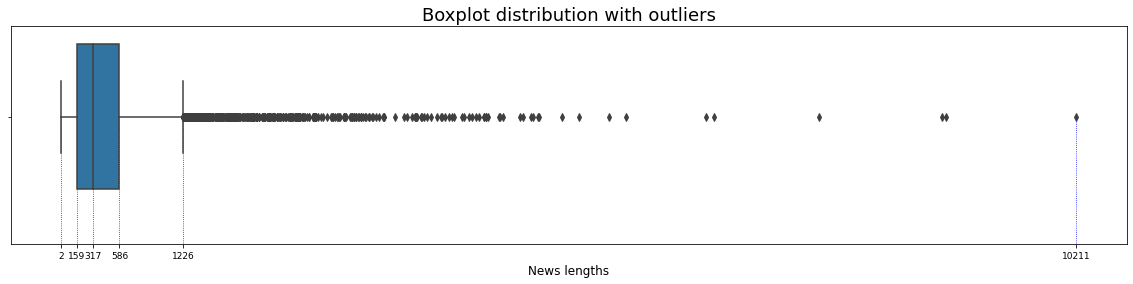

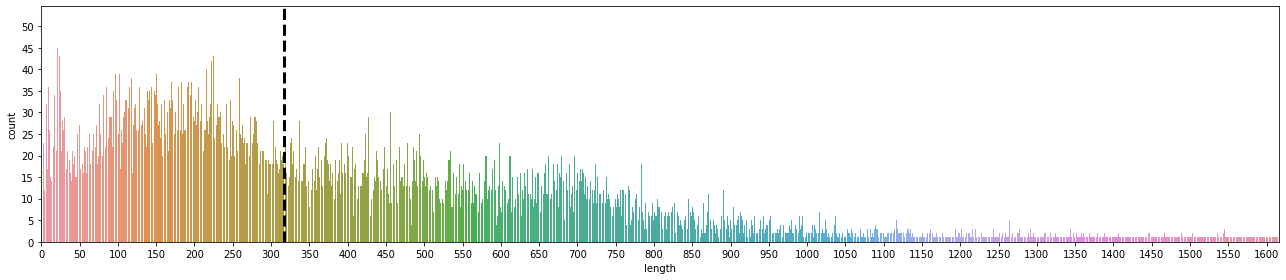

Training Set shape: (13316, 3)
Validation Set shape: (3330, 3)
Test Set shape: (4035, 2)


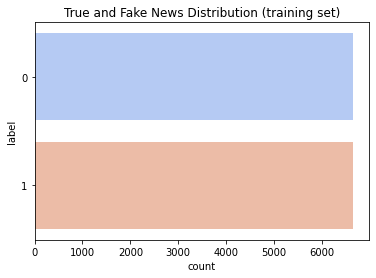

Number of True News in the Training Set: 6658
Number of Fake News in the Training Set: 6658


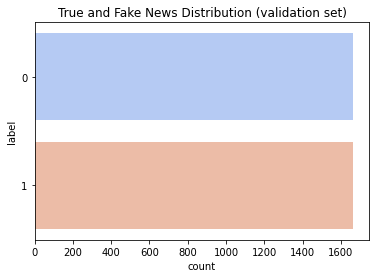

Number of True News in the Validation Set: 1665
Number of Fake News in the Validation Set: 1665


In [5]:
from data_preprocessing import unique_words, padded_train, padded_val, padded_test, Y_train, Y_val, Y_test, median, word_index

# Model Selection

Pre-trained Word Embedding with FastText

In [6]:
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('/content/drive/Shareddrives/ProgettoHLT/FakeNewsDetection/wiki-news-300d-1M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


999995it [01:21, 12256.50it/s]

found 999995 word vectors


In [7]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(unique_words, len(word_index))+1
embedding_matrix = np.zeros((nb_words, 300))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 50608


In [8]:
class MyHyperModel(HyperModel):

  def build(self, hp):

    model = Sequential()
    
    model.add(Embedding(nb_words, weights=[embedding_matrix], output_dim = 300, input_length=median))                                  
    
    model.add(Bidirectional(LSTM(units=hp.Choice('LSTM_units', values=[32, 64, 128]), return_sequences= True)))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(rate=hp.Choice('rate_dropout', values=[0.1, 0.2, 0.3, 0.4, 0.5]))) 
   
    model.add(Dense(units=hp.Choice('dense_units', values=[32, 64, 128]), activation="relu"))
    model.add(Dense(1,activation= 'sigmoid'))
    
    model.compile(optimizer=Adam(lr= hp.Choice('learning_rate', values=[1e-4, 0.5e-3, 1e-3, 0.5e-2, 1e-2]), clipnorm= hp.Choice('clip_norm', values= [1, 3, 5])), loss="binary_crossentropy", metrics=['accuracy'])

    return model

In [9]:
# Add BatchSize HyperParameter via overriding "run_trial"
class MyTuner(RandomSearch):
  def run_trial(self, trial, *args, **kwargs):
    kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size', values=[16, 32, 64, 128]) 
    return super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [10]:
# Random Search setting
tuner = MyTuner(
    MyHyperModel(),
    objective = Objective('val_accuracy', 'max'), 
    max_trials = 60,                                                 
    executions_per_trial = 1,
    overwrite=True
)

In [11]:
tuner.search_space_summary(extended=True)

Search space summary
Default search space size: 5
LSTM_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
rate_dropout (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4, 0.5], 'ordered': True}
dense_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.0005, 0.001, 0.005, 0.01], 'ordered': True}
clip_norm (Choice)
{'default': 1, 'conditions': [], 'values': [1, 3, 5], 'ordered': True}


In [12]:
Y_train = np.asarray(Y_train)

In [13]:
# Random Search execution
es = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', restore_best_weights=True, verbose=1)
tuner.search(padded_train, Y_train, epochs=20, validation_data=(padded_val, Y_val), callbacks=[es]) 

Trial 60 Complete [00h 01m 56s]
val_accuracy: 0.9834834933280945

Best val_accuracy So Far: 0.9885885715484619
Total elapsed time: 02h 34m 53s


In [14]:
# Random Search 10 best results
tuner.results_summary() 

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
LSTM_units: 64
rate_dropout: 0.3
dense_units: 32
learning_rate: 0.005
clip_norm: 3
batch_size: 128
Score: 0.9885885715484619
Trial summary
Hyperparameters:
LSTM_units: 128
rate_dropout: 0.3
dense_units: 128
learning_rate: 0.005
clip_norm: 5
batch_size: 32
Score: 0.9873873591423035
Trial summary
Hyperparameters:
LSTM_units: 128
rate_dropout: 0.1
dense_units: 32
learning_rate: 0.0005
clip_norm: 1
batch_size: 16
Score: 0.9864864945411682
Trial summary
Hyperparameters:
LSTM_units: 128
rate_dropout: 0.1
dense_units: 32
learning_rate: 0.001
clip_norm: 3
batch_size: 32
Score: 0.9864864945411682
Trial summary
Hyperparameters:
LSTM_units: 32
rate_dropout: 0.3
dense_units: 64
learning_rate: 0.001
clip_norm: 1
batch_size: 16
Score: 0.9861862063407898
Trial summary
Hyperparameters:
LSTM_units: 64
rate_dropout: 0.2
dense_units: 32
learning_rate: 0.01
clip_norm: 3
batch_size: 64
Score: 0.9849849939346

In [15]:
# Focus on Best Trial
tuner.oracle.get_best_trials()[0].get_state()

{'trial_id': '46',
 'hyperparameters': {'space': [{'class_name': 'Choice',
    'config': {'name': 'LSTM_units',
     'default': 32,
     'conditions': [],
     'values': [32, 64, 128],
     'ordered': True}},
   {'class_name': 'Choice',
    'config': {'name': 'rate_dropout',
     'default': 0.1,
     'conditions': [],
     'values': [0.1, 0.2, 0.3, 0.4, 0.5],
     'ordered': True}},
   {'class_name': 'Choice',
    'config': {'name': 'dense_units',
     'default': 32,
     'conditions': [],
     'values': [32, 64, 128],
     'ordered': True}},
   {'class_name': 'Choice',
    'config': {'name': 'learning_rate',
     'default': 0.0001,
     'conditions': [],
     'values': [0.0001, 0.0005, 0.001, 0.005, 0.01],
     'ordered': True}},
   {'class_name': 'Choice',
    'config': {'name': 'clip_norm',
     'default': 1,
     'conditions': [],
     'values': [1, 3, 5],
     'ordered': True}},
   {'class_name': 'Choice',
    'config': {'name': 'batch_size',
     'default': 16,
     'conditions':

In [16]:
# Best HyperParameters
best_hps = tuner.get_best_hyperparameters()[0]

In [17]:
best_hps.values

{'LSTM_units': 64,
 'rate_dropout': 0.3,
 'dense_units': 32,
 'learning_rate': 0.005,
 'clip_norm': 3,
 'batch_size': 128}

In [18]:
# Best Model
best_model = tuner.hypermodel.build(best_hps)

In [19]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 317, 300)          32112300  
                                                                 
 bidirectional_1 (Bidirectio  (None, 317, 128)         186880    
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 1)                